In [78]:

import os
import sys
import numpy as np
import load_trace
import fixed_env as env


TRAIN_TRACES = '/root/repos/ABR-Starlink/src/train/'
all_cooked_time, all_cooked_bw, all_file_names,all_cooked_rtt = load_trace.load_trace(TRAIN_TRACES)

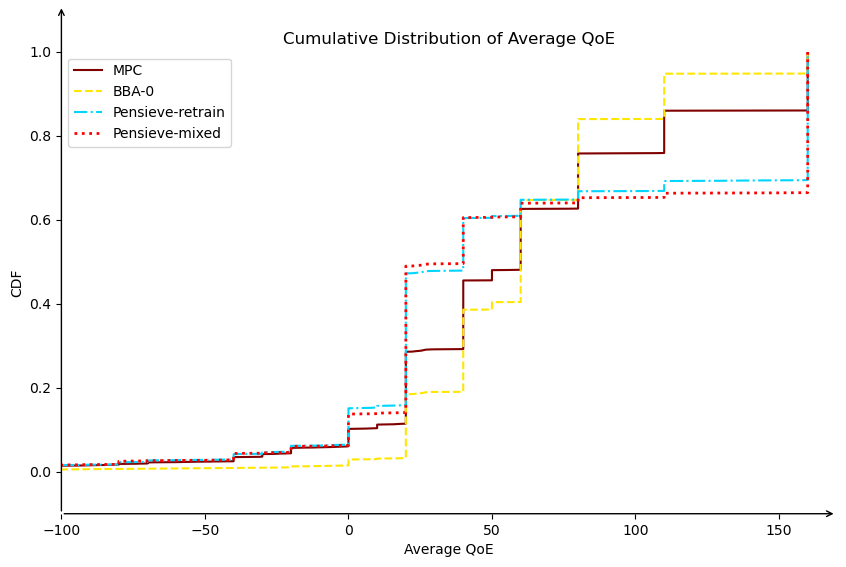

In [4]:
from cProfile import label
import os
import numpy as np
import matplotlib.pyplot as plt


LOG_FILE_PATH = "./test_results/"

log_file_paths = {
    "MPC": LOG_FILE_PATH + "MPC",
    "BBA-0": LOG_FILE_PATH + "bba-0",
    # "RBA": LOG_FILE_PATH + "RBA",
    # "Pensieve-origin": LOG_FILE_PATH + "Pensieve",
    "Pensieve-retrain": LOG_FILE_PATH + "Pensieve-retrain",
    "Pensieve-mixed": LOG_FILE_PATH + "Pensieve-modify",
}


fig, ax = plt.subplots(figsize=(10, 6))
COLOR_MAP = plt.cm.jet_r
linestyles = ["-", "--", "-.", ":"]

for abr_policy, log_path in log_file_paths.items():
    all_rewards = []

    for filename in os.listdir(log_path):
        file_path = os.path.join(log_path, filename)
        if os.path.isfile(file_path):
            with open(file_path, "r") as file:
                for line in file:
                    parts = line.strip().split()
                    if parts:
                        try:
                            reward = float(parts[7])
                            all_rewards.append(reward)
                        except ValueError:
                            continue

    sorted_rewards = np.sort(all_rewards)
    cdf_values = np.arange(1, len(sorted_rewards) + 1) / len(sorted_rewards)
    plt.plot(sorted_rewards, cdf_values, label=abr_policy)

colors = [COLOR_MAP(i) for i in np.linspace(0, 1, len(ax.lines))]
for i, j in enumerate(ax.lines):
    j.set_color(colors[i])
    j.set_linestyle(linestyles[i % len(linestyles)])
    if i == 3:
        j.set_color('red')
        # j.set_alpha(0.5)
        j.set_linewidth(2)

ax.annotate("", xy=(1, -0.1), xytext=(0, -0.1), xycoords=ax.get_yaxis_transform(), arrowprops=dict(arrowstyle="->", color="black"))
ax.annotate("", xy=(-100, 1.1), xytext=(-100, 0), xycoords=ax.get_xaxis_transform(), arrowprops=dict(arrowstyle="->", color="black"))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.xlabel("Average QoE")
plt.ylabel("CDF")
plt.xlim(-100, max(sorted_rewards) + 10)
plt.ylim(-0.1, 1)
plt.title("Cumulative Distribution of Average QoE")
plt.grid(False)
plt.legend()
plt.show()

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt


LOG_FILE_PATH = "./test_results/"

log_file_paths = {
    "BBA-0": LOG_FILE_PATH + "bba-0",
    "RBA": LOG_FILE_PATH + "RBA",
    "MPC": LOG_FILE_PATH + "MPC",
    "Pensieve-origin": LOG_FILE_PATH + "Pensieve",
    "Pensieve-retrain": LOG_FILE_PATH + "Pensieve-retrain",
    "Pensieve-mixed": LOG_FILE_PATH + "Pensieve-modify",
}

VIDEO_BIT_RATE = np.array([20000, 40000, 60000, 80000, 110000, 160000])
all_br = []
all_rebuf = []
all_smooth = []
for abr_policy, log_path in log_file_paths.items():
    br_list = []
    rebuf_list = []
    smooth_list = []
    for filename in os.listdir(log_path):
        file_path = os.path.join(log_path, filename)
        if os.path.isfile(file_path):
            with open(file_path, "r") as file:
                for line in file:
                    parts = line.strip().split()
                    if parts:
                        try:
                            br_list.append(VIDEO_BIT_RATE[int(parts[10])]/100000 * 0.6)
                            rebuf_list.append(float(parts[3])*10)
                            smooth_list.append(int(parts[8])/100000)
                        except:
                            continue
    all_br.append(br_list)
    all_rebuf.append(rebuf_list)
    all_smooth.append(smooth_list)

values = [[], [], []]   # Bitrate utility, Rebuffering penalty, Smoothness penalty
errors = [[], [], []]   # Bitrate utility, Rebuffering penalty, Smoothness penalty
for i in range(6):
    values[0].append(np.mean(np.array(all_br[i])))
    errors[0].append(np.var(np.array(all_br[i])))
    values[1].append(np.mean(np.array(all_rebuf[i])))
    errors[1].append(np.var(np.array(all_rebuf[i]))/80)
    values[2].append(np.mean(np.array(all_smooth[i])))
    errors[2].append(np.var(np.array(all_smooth[i])))

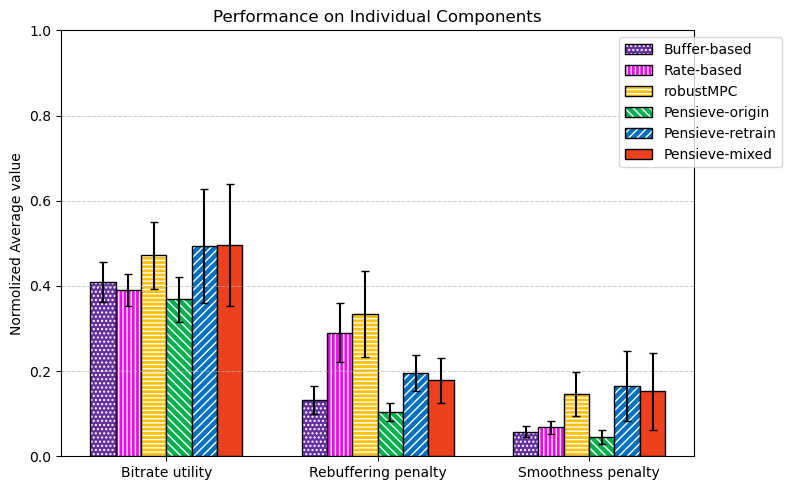

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Data
categories = ['Bitrate utility', 'Rebuffering penalty', 'Smoothness penalty']
methods = ['Buffer-based', 'Rate-based', 'robustMPC', 'Pensieve-origin', 'Pensieve-retrain', 'Pensieve-mixed']

# Bar colors and patterns
colors = ['#6531a0', '#f800f9', '#ffc106', '#00b050', '#0070c0', '#ed411d']
hatch_patterns = ['....', '||||', '----', '\\\\\\\\', '////', '']

# Create the figure and axes
x = np.arange(len(categories))  # Group positions
bar_width = 0.12
offsets = np.linspace(-bar_width * 2.5, bar_width * 2.5, len(methods))

fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars for each method
for i, method in enumerate(methods):
    ax.bar(x + offsets[i], [val[i] for val in values], bar_width,
           yerr=[err[i] for err in errors], label=method,
           color=colors[i], hatch=hatch_patterns[i], capsize=3, edgecolor='black')

# Customize the axes and grid
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel('Normolized Average value')
ax.set_ylim(0, 1)
ax.set_title('Performance on Individual Components')
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0))

# Show plot
plt.tight_layout()
plt.show()
